# Tatoeba Analytics

This notebook aims at generating and visualizing statistics related to the [Tatoeba project](https://tatoeba.org).

## Environment setup

Install the dependencies with:
```sh
$ pip install iso639-lang jinja2 matplotlib pandas tatoebatools wordfreq[cjk]
```

In [1]:
import sqlite3
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd

from iso639 import Lang
from iso639.exceptions import DeprecatedLanguageValue, InvalidLanguageValue
from tatoebatools import tatoeba
from wordfreq import tokenize

# local SQLite database
con = sqlite3.connect("tatostat.db")

In [2]:
# generate the table of sentences
with con:
    con.execute("DROP TABLE IF EXISTS sentences_detailed")
    con.execute(
        """
        CREATE TABLE sentences_detailed (
            sentence_id INTEGER PRIMARY KEY,
            lang TEXT,
            text TEXT,
            username TEXT,
            date_added TIMESTAMP,
            date_last_modified TIMESTAMP
        )
        """
    )
    tatoeba.get("sentences_detailed", "*").to_sql(
        "sentences_detailed", con, if_exists="append", index=True
        )

    # as the 'date_added' values of many sentences are unclear,
    # a 'year_added' column is appended to the sentences_detailed table:
    # - all sentences added before 2012 are merged into 2011
    # - when the date_added value is null, the most likely year 
    #   according to the sentence id is allocated
    con.execute("ALTER TABLE sentences_detailed ADD year_added INT;")
    min_ids = [row for row in con.execute(
        """
        SELECT
          year_added,
          MIN(sentence_id)
        FROM (
          SELECT
            sentence_id,
            CAST(STRFTIME("%Y", date_added) AS INT) AS year_added
          FROM sentences_detailed
        )
        WHERE year_added >= 2012
        GROUP BY year_added
        ORDER BY year_added ASC
        """
    )]
    years_added = [
      (next((m[0] - 1 for m in min_ids if row[0] < m[1]), min_ids[-1][0]), row[0])
      for row in con.execute("SELECT sentence_id FROM sentences_detailed")
    ]
    con.executemany(
      "UPDATE sentences_detailed SET year_added = ? WHERE sentence_id = ?",
      years_added
    )

# generate the table of links
with con:
    con.execute("DROP TABLE IF EXISTS links")
    con.execute(
        """
        CREATE TABLE links (
            sentence_id INT,
            translation_id INT,
            PRIMARY KEY (sentence_id, translation_id)
        )
        """
    )
    tatoeba.get("links", ("*", "*")).to_sql(
      "links", con, if_exists="append", index=False
    )

## Community of contributors


### Monthly active users and monthly acquired users

<AxesSubplot:title={'center':"Size of the contributors' community"}, xlabel='year', ylabel='Number of contributors'>

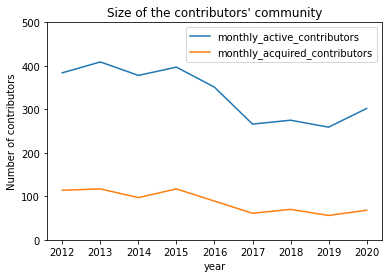

In [16]:
# monthly active users over time
df_monthly_active = pd.read_sql_query(
	"""
	WITH contributors_monthly_activity AS (
		SELECT DISTINCT
		  username,
		  year_added AS year_active,
		  IFNULL(
			CAST(STRFTIME("%m", date_added) AS INT), 
			(SELECT abs(random()) % 12 + 1)
		  ) AS month_active
		FROM sentences_detailed
		WHERE username IS NOT NULL
	)
	SELECT
	  year_active AS year,
	  CAST(AVG(month_contributors) AS INT) AS monthly_active_contributors
	FROM (
		SELECT 
		  year_active,
		  month_active,
		  COUNT(*) AS month_contributors
		FROM contributors_monthly_activity
		GROUP BY year_active, month_active
	)
	WHERE year_active > 2011 
	  AND year_active < 2021
	GROUP BY year_active 
	ORDER BY year_active, month_active;
	""",
	con
)

# monthly acquired users over time
df_monthly_acquired = pd.read_sql_query(
	"""
	WITH contributors_first_activity AS (
		WITH contributors_monthly_activity AS (
	    	SELECT DISTINCT
	      	  username,
		  	  year_added AS year_active,
		  	  IFNULL(
				CAST(STRFTIME("%m", date_added) AS INT), 
				(SELECT abs(random()) % 12 + 1)
			  ) AS month_active
	    	FROM sentences_detailed
	    	WHERE username IS NOT NULL
	  	)
	  	SELECT
	      username, 
		  year_active AS first_year_active,
		  month_active AS first_month_active
	  	FROM (
	    	SELECT 
	      	  username, 
		  	  year_active,
		  	  month_active,
		  	  ROW_NUMBER () OVER ( 
				PARTITION BY username
				ORDER BY year_active ASC, month_active ASC
			  ) nb_row
			FROM contributors_monthly_activity
	  	)
	  	WHERE nb_row = 1
	)
	SELECT
	  first_year_active AS year,
	  CAST(AVG(month_contributors) AS INT) AS monthly_acquired_contributors
	FROM (
		SELECT 
		  first_year_active,
		  first_month_active,
		  COUNT(*) AS month_contributors
		FROM contributors_first_activity
		GROUP BY first_year_active, first_month_active
	)
	WHERE first_year_active > 2011
	  AND first_year_active < 2021
	GROUP BY first_year_active 
	ORDER BY first_year_active, first_month_active;
	""",
	con
)

# plot dataframes
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="white")

df_monthly_active.plot(
	ax=ax, 
	x='year', 
	y='monthly_active_contributors',
	title="Size of the contributors' community",
    xlabel='Year',
    ylabel='Number of contributors',
	ylim=(0, 500)
)

df_monthly_acquired.plot(
	ax=ax, 
	x='year',
	y="monthly_acquired_contributors"
)

### Monthly additions per contributor

<AxesSubplot:title={'center':'Monthly additions per contributor'}, xlabel='Year', ylabel='Number of additions'>

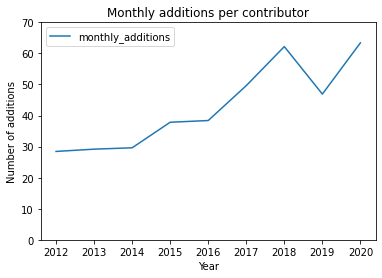

In [17]:
# monthly additions per contributor over time

df_monthly_additions = pd.read_sql_query(
	"""
	SELECT
	  year_added AS year,
	  AVG(nb_sentences) / 12 monthly_additions
	FROM
	(
		SELECT
	      year_added,
		  username,
          COUNT(*) AS nb_sentences
		FROM sentences_detailed
		WHERE year_added >= 2012 AND year_added < 2021
        GROUP BY year_added, username
	)
	GROUP BY year_added
	ORDER BY year ASC
	""",
	con
)

# plot dataframe
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="white")
df_monthly_additions.plot(
	ax=ax, 
	x="year",
	y="monthly_additions",
	title="Monthly additions per contributor",
	xlabel='Year', 
	ylabel='Number of additions', 
	ylim=(0, 70)
)

## Originality of the sentences

For a corpus to be diverse, it must contain significant amounts of original sentences. An added sentence can be considered original if it includes many words that do not appear in a similar context elsewhere in the corpus.

We can therefore measure the originality of a sentence by splitting it into sequences of N consecutive words (a.k.a. [n-grams](https://en.wikipedia.org/wiki/N-gram)) and calculating the proportion of sequences that were new at the time of addition. This originality score ranges from 0 to 1. When all the n-grams of a sentence are new, it has a maximum originality of 1. On the other hand, when all the n-grams of a sentence have already been observed in other sentences, it is considered as unoriginal and has a score of 0.

The number N of tokens per n-gram impacts the originality scores. The higher N is, the higher the probability that a n-gram is original and therefore the higher the originality score. On the other hand, the relevance of the score decreases with N because the more two words are distant in a sentence, the less likely that they are interrelated. The use of trigrams seems to offer a good compromise.

### Scoring the originality of the sentences

In [5]:
# compute the originality-related data (takes several minutes)

# N is the length of n-grams
# when a sentence has less tokens than N, the shorter sequence
# that is generated is processed as any standard n-gram 
N = 3  

# the tokenizer of the wordfreq library that is used to generate n-grams 
# is fast and covers a large number of languages, including CJK languages

def get_tokenizer_lang(language):
    """Get the language code to be passed to the tokenizer

    The wordfreq tokenizer accept most ISO 639 codes as 
    language parameter. The English tokenizer is chosen as a 
    substitute for the few unrecognized language codes.

    Parameters
    ----------
    language : str
        the Tatoeba language code (mostly ISO 639-3 codes)

    Returns
    -------
    str
        an ISO 639 language code, as required by the wordfreq 
        tokenizer
    """
    try:
        lg = Lang(language)
    except (InvalidLanguageValue, DeprecatedLanguageValue, TypeError):
        return "eng"
    else:
        return next((v for v in (lg.pt1, lg.pt3, lg.pt2b) if v), "eng")


# in order to simulate the building of the corpus over time, the program 
# iterates over all sentences in ascending id order and evaluates the newness 
# of the n-grams they contain
with con:
    con.execute("DROP TABLE IF EXISTS originalities;")
    con.execute(
        """
        CREATE TABLE originalities (
            'sentence_id' INTEGER NOT NULL PRIMARY KEY,
            'nb_new_ngrams' INT NOT NULL,
            'originality' REAL NOT NULL,
            'original_text' TEXT
        );
        """
    )
    
    ngrams = {}
    for row in con.execute(
            """
            SELECT 
                sentence_id, 
                lang, 
                text 
            FROM sentences_detailed 
            ORDER BY sentence_id ASC;
            """
        ):
        tk_lg = get_tokenizer_lang(row[1])
        
        tokens = tokenize(row[2], tk_lg)
        # alternative used in v1 -> tokens = ["["] + tokenize(s.text, tk_lg) + ["]"]

        # assess the newness of the n-grams of the sentence.
        ngrams_newness = []
        for i in range(max(len(tokens)-N+1, 1)):
            ngram = tuple(tokens[i:i+N])
            ngrams.setdefault(row[1], defaultdict(int))[ngram] += 1
            ngrams_newness.append(ngrams[row[1]][ngram] <= 1)

        nb_new_ngrams = sum(1 for x in ngrams_newness if x)
        originality = nb_new_ngrams / len(ngrams_newness)

        # the new n-grams are merged to form an 'original_text' string
        original_intervals = (range(i, i+N) for i, nw in enumerate(ngrams_newness) if nw)
        original_indices = sorted({i for itv in original_intervals for i in itv})
        original_tokens = (tokens[i] for i in original_indices if i < len(tokens))
        original_text = " ".join(original_tokens)

        # insert the results into the database
        con.execute(
            """
            INSERT INTO originalities
            VALUES (:sentence_id, :nb_new_ngrams, :originality, :original_text);
            """,
            {
                'sentence_id': row[0], 
                "nb_new_ngrams": nb_new_ngrams,
                "originality": originality,
                "original_text": original_text
            },
        )

Building prefix dict from /home/lbdx/tatostat/env_tatostat/lib/python3.8/site-packages/wordfreq/data/jieba_zh.txt ...
Building prefix dict from /home/lbdx/tatostat/env_tatostat/lib/python3.8/site-packages/wordfreq/data/jieba_zh.txt ...
Dumping model to file cache /tmp/jieba.u3d88cef6532809c8c32a30f78d11c4b2.cache
Dumping model to file cache /tmp/jieba.u3d88cef6532809c8c32a30f78d11c4b2.cache
Loading model cost 0.055 seconds.
Loading model cost 0.055 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.
The language 'th' is in the 'Thai' script, which we don't have a tokenizer for. The results will be bad.
The language 'km' is in the 'Khmr' script, which we don't have a tokenizer for. The results will be bad.
The language 'lo' is in the 'Laoo' script, which we don't have a tokenizer for. The results will be bad.
The language 'mnw' is in the 'Mymr' script, which we don't have a tokenizer for. The results will be bad.
The language 'my' is in the 'Mymr' 

### Distribution of originality scores

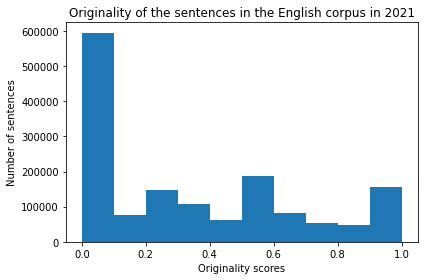

In [18]:
# plot the distribution of sentence originality scores by language

lg = "eng"
max_year = 2021
nb_bins = 10

df_originalities = pd.read_sql_query(
    f"""
    SELECT og.originality 
    FROM sentences_detailed AS st
    INNER JOIN originalities AS og
      ON st.sentence_id = og.sentence_id
    WHERE st.lang ='{lg}' 
      AND year_added <= {max_year}
    """,
    con
)

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="white")

# the histogram of the data
n, bins, patches = ax.hist(
    df_originalities.loc[:,'originality'].values, 
    bins=nb_bins, 
    density=False
)

# add title and labels
ax.set_title(f'Originality of the sentences in the {Lang(lg).name} corpus in {max_year}')
ax.set_xlabel('Originality scores')
ax.set_ylabel('Number of sentences')

# tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

### Contributors of unoriginal sentences

In [19]:
# identify the main contributors of unoriginal sentences by language

lg = "eng"

df = pd.read_sql_query(
	f"""
  WITH lang_unoriginal_sentences AS (
    SELECT 
      st.sentence_id, 
      st.username
    FROM sentences_detailed AS st
    INNER JOIN originalities AS og
      ON st.sentence_id = og.sentence_id
    WHERE og.originality = 0 
      AND st.lang = "{lg}"
  )
  SELECT 
    username, 
    COUNT(*) AS nb_unoriginals
  FROM lang_unoriginal_sentences
  GROUP BY username
  ORDER BY nb_unoriginals DESC;
	""",
	con,
  index_col="username"
)
df['pct_unoriginals'] = df['nb_unoriginals'] / df['nb_unoriginals'].sum() * 100

df.rename(
	columns={
		'nb_unoriginals': 'number of unoriginal sentences',
 		'pct_unoriginals': f'percentage of all unoriginal sentences'
	}, 
	inplace=True
)

# generate and format output
df.head(
  10
).style.set_caption(
	f"Top contributors of {Lang(lg).name} unoriginal sentences"
).format(
	precision=1, 
	na_rep=''
)

,number of unoriginal sentences,percentage of all unoriginal sentences
username,,
CK,351495,59.7
CH,54896,9.3
CT,26498,4.5
CF,19885,3.4
OsoHombre,19055,3.2
Amastan,18957,3.2
CM,15018,2.5
Hybrid,14789,2.5
sundown,3789,0.6


### Share of unoriginal sentences over time

In [3]:
# track the share of unoriginal sentences (originality = 0) by language over time

min_corpus_size = 200000 # only process largest corpora

df = pd.read_sql_query(
	f"""
	WITH top_langs AS (
		SELECT lang
		FROM (
			SELECT 
			  lang, 
			  COUNT(*) AS nb_sentences
			FROM sentences_detailed
			GROUP BY lang
		)
		WHERE nb_sentences >= {min_corpus_size} 
	)
	SELECT
		lang AS language,
		year_added AS year,
		100.0 *	SUM(nb_unoriginals) OVER (
				PARTITION BY lang
				ORDER BY year_added
				ROWS UNBOUNDED PRECEDING
			) /  
			SUM(nb_sentences) OVER (
				PARTITION BY lang
				ORDER BY year_added
				ROWS UNBOUNDED PRECEDING
		) AS pct_unoriginal
	FROM (
		SELECT
			st.lang,
			year_added,
			COUNT(*) AS nb_sentences,
			SUM(og.originality = 0) AS nb_unoriginals
		FROM sentences_detailed AS st
		INNER JOIN originalities AS og
			ON st.sentence_id = og.sentence_id
		WHERE lang IN top_langs
		GROUP BY lang, year_added
	)
	""",
	con
)

# replace language codes by language names
df["language"] = df["language"].apply(lambda x: Lang(x).name)

# pivot the dataframe
df = df.pivot(
	index="language", 
	columns="year", 
	values="pct_unoriginal"
).sort_values(
	by=2021, 
	ascending=False
)

# generate and format output
df.style.set_caption(
	"Percentage of unoriginal sentences in the corpora over time"
).format(formatter=None,
	precision=1, 
	na_rep=''
)

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
language,,,,,,,,,,,
English,10.5,13.3,17.6,20.7,23.7,24.6,33.2,39.9,39.7,39.4,38.9
Italian,6.5,10.8,17.6,21.1,24.5,26.1,27.4,36.3,36.5,36.8,36.8
Berber languages,,6.6,8.7,9.1,9.9,9.9,10.0,11.5,14.1,17.3,23.6
Kabyle,,0.0,,,,0.0,0.0,6.0,7.6,23.6,23.6
Portuguese,4.8,6.7,8.0,8.4,9.4,12.6,13.6,16.2,17.2,18.0,18.3
Russian,2.0,2.9,5.9,7.9,10.5,12.8,13.8,15.6,16.5,17.7,17.7
French,6.4,10.3,12.4,12.9,13.9,14.9,15.4,16.0,16.8,17.3,17.5
Esperanto,5.4,6.5,8.1,9.2,9.7,11.4,12.0,12.4,12.7,13.3,13.4
German,4.0,5.5,6.2,7.0,7.6,8.0,8.3,9.9,10.5,11.2,11.9


## Bulk addition of sentences

When a large number of sentences are added by the same user during the same minute, they are considered as bulk-added. These additions can be performed by site admins, by bots, or even by fast copy-pasters.

### Detecting bullk-added sentences

In [21]:
# detect bulk-added sentences

# more than the below value of additions per user per minute 
# is considered bulk
add_per_min = 20 

with con:
    con.execute("DROP TABLE IF EXISTS bulk_additions")
    con.execute(
        """
        CREATE TABLE bulk_additions (
            sentence_id INTEGER PRIMARY KEY,
            is_bulk_added BOOLEAN
        )
        """
    )
    con.execute(
        f"""
        INSERT INTO bulk_additions
        SELECT
            sd.sentence_id,
            ba.minute_added IS NOT NULL AS is_bulk_added
        FROM sentences_detailed AS sd 
        LEFT JOIN (
            SELECT 
                username,
                minute_added
            FROM (
                SELECT 
                    username,
                    DATETIME(STRFTIME("%Y-%m-%d %H:%M", date_added)) AS minute_added,
                    COUNT(*) AS nb_sentences_added
                FROM sentences_detailed AS st 
                WHERE date_added IS NOT NULL 
                    AND year_added >= 2012
                GROUP BY username, minute_added
            )
            WHERE nb_sentences_added >= {add_per_min}
            ORDER BY username ASC, minute_added ASC
        ) AS ba 
          ON (
            (sd.username, DATETIME(STRFTIME("%Y-%m-%d %H:%M", sd.date_added))) 
            = (ba.username, ba.minute_added)
        )
        """
    )

### Top bulk contributors

In [22]:
# identify the main contributors of bulk-added sentences

df = pd.read_sql_query(
        """
        SELECT
          sd.username,
          sd.lang,
          COUNT(*) AS nb_bulk_added_sentences,
          100.0 * SUM(og.originality = 0) / COUNT(*) AS pct_unoriginal
        FROM sentences_detailed sd 
        INNER JOIN bulk_additions ba 
          ON sd.sentence_id = ba.sentence_id 
        INNER JOIN originalities og
          ON sd.sentence_id = og.sentence_id 
        WHERE is_bulk_added = TRUE
        GROUP BY username, lang
        ORDER BY nb_bulk_added_sentences DESC 
        LIMIT 20
        """,
        con,
        index_col="username"
)

df.rename(
	columns={
		'nb_bulk_added_sentences': 'number of bulk-added sentences',
 		'pct_unoriginal': "percentage of unoriginal sentences among bulk-additions"
	}, 
	inplace=True
)

df.style.set_caption(
	"Top contributors of bulk-added sentences"
).format(
	precision=1, 
	na_rep=''
)

,lang,number of bulk-added sentences,percentage of unoriginal sentences among bulk-additions
username,,,
CK,eng,428261,58.9
Guybrush88,ita,126459,72.3
CH,eng,63251,76.3
CT,eng,39082,67.6
Aghsi_n_Unezruf,ber,37323,56.7
CM,eng,34055,33.4
CF,eng,31449,63.0
deniko,ukr,14983,13.7
turita,tur,10173,33.3


### Unoriginality and bulk addition

In [23]:
# compare bulk additions of original sentences with bulk additions of 
# unoriginal sentences

df = pd.read_sql_query(
        """
        SELECT
          CASE 
            WHEN og.originality = 0 
            THEN 'UNORIGINAL' 
            ELSE 'NOT UNORIGINAL' 
          END AS is_unoriginal,
          100.0 * SUM(ba.is_bulk_added) / COUNT(*) AS pct_bulk_added
        FROM sentences_detailed sd 
        INNER JOIN bulk_additions ba 
          ON sd.sentence_id = ba.sentence_id 
        INNER JOIN originalities og
          ON sd.sentence_id = og.sentence_id 
        GROUP BY is_unoriginal
        ORDER BY is_unoriginal DESC
        """,
        con,
        index_col="is_unoriginal"
)

df.rename(
  columns={'pct_bulk_added': 'percentage of bulk-added sentences'}, 
	inplace=True
)

df.style.set_caption(
	"Link between unoriginal sentences and bulk additions"
).format(
	precision=1, 
	na_rep=''
)

,percentage of bulk-added sentences
is_unoriginal,
UNORIGINAL,26.9
NOT UNORIGINAL,4.5


<AxesSubplot:title={'center':'Sentences added in bulk to the English corpus'}, xlabel='Year of addition', ylabel='Number of sentences'>

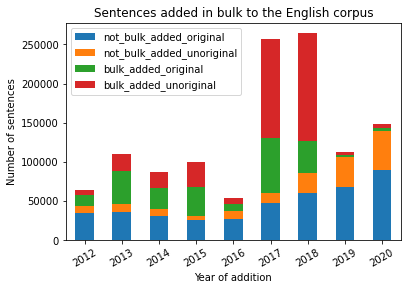

In [24]:
# track the originality of bulk additions over time

lg = "eng"

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="white")

pd.read_sql_query(
        f"""
        SELECT
          year_added,
          SUM(ba.is_bulk_added = FALSE AND og.originality > 0) AS not_bulk_added_original,
          SUM(ba.is_bulk_added = FALSE AND og.originality = 0) AS not_bulk_added_unoriginal,
          SUM(ba.is_bulk_added = TRUE AND og.originality > 0) AS bulk_added_original,
          SUM(ba.is_bulk_added = TRUE AND og.originality = 0) AS bulk_added_unoriginal
        FROM sentences_detailed sd 
        INNER JOIN bulk_additions ba 
          ON sd.sentence_id = ba.sentence_id 
        INNER JOIN originalities og
          ON sd.sentence_id = og.sentence_id 
        WHERE sd.lang = "{lg}"
          AND year_added >= 2012
          AND year_added < 2021
        GROUP BY year_added
        ORDER BY year_added ASC 
        """,
        con,
        index_col="year_added"
).plot.bar(
  ax=ax, 
  stacked=True, 
  rot=30, 
  title=f'Sentences added in bulk to the {Lang(lg).name} corpus',
  xlabel='Year of addition',
  ylabel='Number of sentences'
)

## Popularity of the sentences

The popularity of a sentence is measured by summing its __*translators*__.

A user is considered as a translator of a source sentence when:
* he is not the owner of the source sentence
* he owns at least one sentence in a language other than the source language that is directly or indirectly linked to the source sentence

In [25]:
# fill a table with translations of distance 1 or distance 2
with con:
    con.execute("DROP TABLE IF EXISTS translations")
    con.execute(
        """
        CREATE TABLE translations (
            sentence_id INT,
            translation_id INT,
            distance INT,
            PRIMARY KEY (sentence_id, translation_id)
        )
        """
    )
    con.execute(
        """
        INSERT INTO translations
        SELECT
            source_sentence AS sentence_id,
            target_sentence AS translation_id,  
            MIN(d) as distance
        FROM
        (
            SELECT DISTINCT
                lk1.sentence_id AS source_sentence,
                CASE
                    WHEN lk1.sentence_id = lk2.translation_id
                    THEN lk2.sentence_id
                    ELSE lk2.translation_id
                END
                AS target_sentence,
                CASE
                    WHEN lk1.sentence_id = lk2.translation_id
                    THEN 1
                    ELSE 2
                END
                AS d
            FROM links AS lk1
            INNER JOIN links AS lk2
                ON lk1.translation_id = lk2.sentence_id
        )
        GROUP BY sentence_id, translation_id
        ORDER BY sentence_id ASC, translation_id ASC
        """
    )
    con.execute(
        """
        CREATE INDEX translations_translation_id_IDX 
        ON translations (translation_id)
        """
    )
    con.execute(
        """
        CREATE INDEX translations_distance_IDX 
        ON translations (distance)
        """
    )

### Scoring the popularities of the sentences

In [26]:
# fill a table with the number of translators by sentence 
with con:
    con.execute("DROP TABLE IF EXISTS popularities")
    con.execute(
        """
        CREATE TABLE popularities (
            sentence_id INTEGER PRIMARY KEY,
            popularity INTEGER
        )
        """
    )
    con.execute(
        """
        INSERT INTO popularities
        SELECT
            s.sentence_id,
            IFNULL(translators.nb_translators, 0) AS popularity
        FROM sentences_detailed AS s
        LEFT JOIN 
        (
            SELECT 
                sentence_id, 
                COUNT(*) AS nb_translators
            FROM 
            (
                SELECT DISTINCT 
                    src_st.sentence_id,
                    tgt_st.username 
                FROM translations AS tl
                INNER JOIN sentences_detailed as tgt_st 
                    ON tl.translation_id  = tgt_st.sentence_id 
                INNER JOIN sentences_detailed as src_st 
                    ON tl.sentence_id  = src_st.sentence_id 
                WHERE IFNULL(src_st.username, "") != IFNULL(tgt_st.username, "")
                    AND IFNULL(src_st.lang, "") != IFNULL(tgt_st.lang, "")
            )
            GROUP BY sentence_id
        ) AS translators
        ON s.sentence_id = translators.sentence_id
        ORDER BY s.sentence_id ASC
        """
    )

### Popularity and originality

<AxesSubplot:title={'center':'Composition of the additions to the English corpus'}, xlabel='Year of addition', ylabel='Number of sentences'>

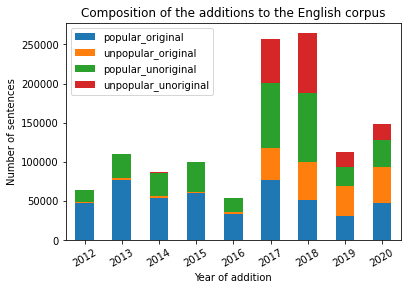

In [27]:
# track the popularity and the originality of sentences over time

lg = "eng"
min_translators = 1

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="white")
pd.read_sql_query(
    f"""
    SELECT
      year_added,
      SUM(po.popularity >= {min_translators} AND og.originality > 0) AS popular_original,
      SUM(po.popularity < {min_translators} AND og.originality > 0) AS unpopular_original,
      SUM(po.popularity >= {min_translators} AND og.originality = 0) AS popular_unoriginal,
      SUM(po.popularity < {min_translators} AND og.originality = 0) AS unpopular_unoriginal
    FROM sentences_detailed AS sd
    INNER JOIN popularities AS po
      ON sd.sentence_id = po.sentence_id
    INNER JOIN originalities og
      ON sd.sentence_id = og.sentence_id 
    WHERE lang = "{lg}"
      AND year_added >= 2012
      AND year_added < 2021
    GROUP BY year_added
    ORDER BY year_added ASC
    """,
    con,
    index_col="year_added"
).plot.bar(
  ax=ax, 
  stacked=True, 
  rot=30,
  title=f'Composition of the additions to the {Lang(lg).name} corpus',
  xlabel='Year of addition',
  ylabel='Number of sentences'
)

In [28]:
# track the share of unpopular/unoriginal sentences by language and year of addition

min_corpus_size = 200000 # only process largest corpora

df = pd.read_sql_query(
	f"""
	WITH top_langs AS (
		SELECT lang
		FROM (
			SELECT 
			  lang, 
			  COUNT(*) AS nb_sentences
			FROM sentences_detailed
			GROUP BY lang
		)
		WHERE nb_sentences >= {min_corpus_size} 
	)
	SELECT
		lang AS language,
		year_added,
		(
			100.0 
			* SUM(po.popularity = 0 AND og.originality = 0) 
			/ COUNT(*) 
		) AS pct_unpopular_unoriginal
	FROM sentences_detailed AS st
	INNER JOIN originalities AS og
		ON st.sentence_id = og.sentence_id
	INNER JOIN popularities AS po
		ON st.sentence_id = po.sentence_id
	WHERE lang IN top_langs
	GROUP BY lang, year_added
	ORDER BY pct_unpopular_unoriginal DESC
	""",
	con
)

# replace language codes by language names
df["language"] = df["language"].apply(lambda x: Lang(x).name)

# pivot the dataframe
df = df.pivot(
	index="language", 
	columns="year_added", 
	values="pct_unpopular_unoriginal"
).sort_values(
	by=2021, 
	ascending=False
)

# generate and format output
df.style.set_caption(
	"Percentage of unpopular/unoriginal sentences by year of addition"
).format(
	precision=1, 
	na_rep=''
)

year_added,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
language,,,,,,,,,,,
Berber languages,,0.1,0.2,0.4,0.2,0.0,0.1,4.4,0.8,9.2,40.7
Kabyle,,0.0,,,,0.0,0.0,2.1,6.2,29.0,19.8
English,0.1,0.0,0.1,0.1,0.0,0.1,22.1,29.0,16.9,14.2,17.8
Portuguese,0.0,0.3,0.4,0.8,0.6,0.6,1.0,8.8,8.2,5.8,5.4
French,0.0,0.0,0.1,0.1,0.2,1.9,0.5,0.7,1.7,4.3,4.2
Russian,0.0,0.0,0.1,0.1,0.2,0.3,1.4,3.1,3.4,5.5,4.0
Italian,0.1,0.2,0.2,6.4,4.2,2.3,0.3,47.6,0.6,1.3,2.3
Esperanto,0.1,0.2,0.3,0.2,0.4,0.8,0.2,0.3,0.8,2.6,1.4
Hungarian,0.0,0.0,0.0,0.2,0.8,0.4,0.2,0.4,1.7,2.2,1.3


## Filtering out unpopular/unoriginal sentences after a while

Run the next cells to simulate the filtering of the unoriginal sentences that are the most unpopular out of the corpus.

In [10]:
min_popularity = 1
before_year = 2019

In [11]:
# simulate a search on Tatoeba

lg = "eng"
word = "supportive"

ok_sentence_ids = {
	2111952, 8680179, 4211774, 6263581, 7426436, 8045278, 8045280, 8416307, 2396159, 
	2883037, 4211949, 8861561, 4211950, 7392388, 9698906, 3122907, 4211951, 9540391 
}

def search(word, language):
	sql =  f"""
			SELECT
				st.sentence_id,
				st.text,
				st.year_added,
				og.originality,
				po.popularity
			FROM sentences_detailed AS st
			INNER JOIN originalities AS og
				ON st.sentence_id = og.sentence_id
			INNER JOIN popularities AS po
				ON st.sentence_id = po.sentence_id
			WHERE st.lang = '{language}' 
				AND st.text LIKE "%{word}%"
			ORDER BY LENGTH(st.text) ASC
			"""

	with con:
		con.row_factory = sqlite3.Row

		return [dict(row) for row in con.execute(sql)]


def filter_original_results(results, min_popularity, before_year):
	
	return [
		res 
		for res in results 
		if res["originality"] > 0 
			or res["year_added"] >= before_year
			or res["popularity"] >= min_popularity
	]


def get_missed_sentence_ids(results, ok_sentence_ids):

	res_ids = set(r["sentence_id"] for r in results)

	return ok_sentence_ids - res_ids


def print_results(results, missed_sentence_ids):

	for i, r in enumerate(results):
		page = i // 10 + 1
		if not ok_sentence_ids or r["sentence_id"] in ok_sentence_ids:
			print(str(page) + "\t" + r["text"])
			
	print("\nmissing", str(sorted(list(missed_sentence_ids))))


raw_results = search(word, lg)
results = filter_original_results(raw_results, min_popularity, before_year)
missed_sentence_ids = get_missed_sentence_ids(results, ok_sentence_ids)

print_results(results, missed_sentence_ids)

1	Be supportive.
3	I tried to be supportive.
3	We need to be supportive.
3	I have a supportive family.
4	Everyone was very supportive.
4	I was trying to be supportive.
5	He has always been supportive.
6	Her boyfriend was not supportive.
6	You're not being very supportive.
7	I should've been more supportive.
7	Thank you for being so supportive.
10	I'm sorry for not being more supportive.
12	To those who have been supportive, thank you.
12	I think you should be a little more supportive.
13	I'm sorry for not being more supportive when you needed me to be.
14	Pope Francis spoke of the need to be generous, supportive and helpful, especially towards those who are vulnerable, the sick, those unemployed or experiencing hardship due to the economic effects of the pandemic, and women who have suffered domestic violence during these months of lockdown.

missing [6263581, 7392388]


In [12]:
# measure the impact of filtering on the share of unoriginal sentences

min_corpus_size = 200000 # only process biggest corpora


df = pd.read_sql_query(
	f"""
	WITH top_langs AS (
		SELECT lang
		FROM (
			SELECT 
			  lang, 
			  COUNT(*) AS nb_sentences
			FROM sentences_detailed
			GROUP BY lang
		)
		WHERE nb_sentences >= {min_corpus_size} 
	)
	SELECT
		lang,
		100.0 * SUM(og.originality = 0) / COUNT(*) AS unoriginals_before,
		100.0 * SUM(
			og.originality = 0 
			AND (
				year_added >= {before_year}
				OR po.popularity >= {min_popularity}
			)
		) / COUNT(*) AS unoriginals_after
	FROM sentences_detailed AS st
	INNER JOIN originalities AS og
	  ON st.sentence_id = og.sentence_id
    INNER JOIN popularities AS po
      ON st.sentence_id = po.sentence_id 
    WHERE lang IN top_langs
	GROUP BY lang
	ORDER BY unoriginals_after DESC
	""",
	con
)
df["lang"] = df["lang"].apply(lambda x: Lang(x).name)

df.rename(
	columns={
		"lang": "language",
		"unoriginals_before": 'percentage of unoriginal sentences in unfiltered corpus',
 		'unoriginals_after': 'percentage of unoriginal sentences in filtered corpus'
	}, 
	inplace=True
)

df.set_index(
	'language'
).style.set_caption(
	f"Share of unoriginal content after filtering out unoriginal sentences \
	added before {before_year} and with a popularity score \
	inferior to {min_popularity}"
).format(precision=1)

,percentage of unoriginal sentences in unfiltered corpus,percentage of unoriginal sentences in filtered corpus
language,,
English,38.9,30.1
Italian,36.8,25.2
Kabyle,23.6,23.3
Berber languages,23.6,22.9
French,17.5,17.2
Russian,17.7,17.1
Portuguese,18.3,16.8
Esperanto,13.4,13.2
German,11.9,11.7


In [13]:
# identify the contributors impacted by the filtering

df = pd.read_sql_query(
    f"""
    SELECT
      username,
      lang,
      SUM(
        og.originality = 0 
        AND po.popularity < {min_popularity}
        AND year_added < {before_year} 
      ) AS nb_discarded,
      (
        100.0 * SUM(
          og.originality = 0 
          AND po.popularity < {min_popularity}
          AND year_added < {before_year} 
        ) 
        / COUNT(*)
      ) AS pct_discarded,
      (
        100.0 * SUM(
          og.originality = 0 
          AND po.popularity < {min_popularity}
          AND year_added < {before_year} 
          AND ba.is_bulk_added = TRUE
        ) 
        / SUM(
          og.originality = 0 
          AND po.popularity < {min_popularity}
          AND year_added < {before_year} 
        )
      ) AS pct_bulk_added_among_discarded
    FROM sentences_detailed AS sd 
    INNER JOIN originalities AS og
      ON sd.sentence_id = og.sentence_id 
    INNER JOIN popularities AS po
      ON sd.sentence_id = po.sentence_id 
    INNER JOIN bulk_additions AS ba
      ON sd.sentence_id = ba.sentence_id 
    GROUP BY username, lang
    ORDER BY nb_discarded DESC
    LIMIT 20
    """,
    con,
    index_col="username"
)

tot_discarded = df['nb_discarded'].sum()
print(f"{tot_discarded} sentences discarded")

df.rename(
	columns={
    "lang" : "language",
    "nb_discarded": "owned discarded sentences",
    "pct_discarded": "percentage of owned sentences that are discarded",
    "pct_bulk_added_among_discarded": "percentage of bulk additions among owned discarded sentences"
	}, 
	inplace=True
)

df.style.set_caption(
	"Top contributors of discarded sentences"
).format(
	precision=1, 
	na_rep=''
)

240452 sentences discarded


,language,owned discarded sentences,percentage of owned sentences that are discarded,percentage of bulk additions among owned discarded sentences
username,,,,
Guybrush88,ita,92397,13.4,87.6
CK,eng,65532,9.8,98.3
CT,eng,21934,55.9,99.7
CF,eng,15481,49.0,99.7
CH,eng,15416,20.7,99.7
OsoHombre,eng,9170,12.2,0.0
marafon,rus,3783,0.9,0.0
CM,eng,3714,6.1,99.6
iart61,por,3246,17.4,49.4
